# Cvxpylayers tutorial

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch
from cvxpylayers.torch import CvxpyLayer
torch.set_default_dtype(torch.double)

np.set_printoptions(precision=3, suppress=True)

## Parametrized convex optimization problem

$$
\begin{array}{ll} \mbox{minimize} & f_0(x;\theta)\\
\mbox{subject to} & f_i(x;\theta) \leq 0, \quad i=1, \ldots, m\\
& A(\theta)x=b(\theta),
\end{array}
$$
with variable $x \in \mathbf{R}^n$ and parameters $\theta\in\Theta\subseteq\mathbf{R}^p$

* objective and inequality constraints $f_0, \ldots, f_m$ are *convex* in $x$ for each $\theta$, *i.e.*, their graphs curve upward
* equality constraints are linear
* for a given value of $\theta$, find a value for $x$ that minimizes objective, while satisfying constraints
* we can efficiently solve these globally with near total reliability

## Solution map
* Solution $x^\star$ is an implicit function of $\theta$
* When unique, define solution map as function
$x^\star = \mathcal S(\theta)$
* Need to call numerical solver to evaluate
* This function is often differentiable
* In a series of papers we showed how to analytically differentiate this function, using the implicit function theorem
* Benefits of analytical differentiation: works with nonsmooth objective/constraints, low memory usage, don't compound errors

## CVXPY
* High level domain-specific language (DSL) for convex optimization
* Define variables, parameters, objective and constraints
* Synthesize into problem object, then call solve method
* We've added derivatives to CVXPY (forward and backward)

## CVXPYlayers
![](https://github.com/cvxgrp/cvxpylayers/blob/master/cvxpylayers_logo.png?raw=true)
* Convert CVXPY problems into callable, differentiable Pytorch and Tensorflow modules in one line

## Applications
* learning convex optimization models (structured prediction): https://stanford.edu/~boyd/papers/learning_copt_models.html
* learning decision-making policies (reinforcement learning): https://stanford.edu/~boyd/papers/learning_cocps.html
* machine learning hyper-parameter tuning and feature engineering: https://stanford.edu/~boyd/papers/lsat.html
* repairing infeasible or unbounded optimization problems: https://stanford.edu/~boyd/papers/auto_repair_cvx.html
* as protection layers in neural networks: http://physbam.stanford.edu/~fedkiw/papers/stanford2019-10.pdf
* custom neural network layers (sparsemax, csoftmax, csparsemax, LML): https://locuslab.github.io/2019-10-28-cvxpylayers/
* and many more... 

## Average example
Find the average of a vector:
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^n (y_i - x)^2
\end{array}
\end{equation}
Variable $x$, parameters $y\in\mathbf{R}^n$

The solution map is clearly:
$$x=\sum_{i=1}^n y_i / n$$

In [2]:
n = 7

# Define variables & parameters
x = cp.Variable()
y = cp.Parameter(n)

# Define objective and constraints
objective = cp.sum_squares(y - x)
constraints = []

# Synthesize problem
prob = cp.Problem(cp.Minimize(objective), constraints)

# Set parameter values
y.value = np.random.randn(n)

# Solve problem in one line
prob.solve(requires_grad=True)
print("solution:", "%.3f" % x.value)
print("analytical solution:", "%.3f" % np.mean(y.value))

solution: 0.177
analytical solution: 0.177


The gradient is simply:
$$\nabla_y x = (1/n)\mathbf{1}$$

In [3]:
# Set gradient wrt x
x.gradient = np.array([1.])

# Differentiate in one line
prob.backward()
print("gradient:", y.gradient)
print("analytical gradient:", np.ones(y.size) / n)

gradient: [0.143 0.143 0.143 0.143 0.143 0.143 0.143]
analytical gradient: [0.143 0.143 0.143 0.143 0.143 0.143 0.143]


## Median example
Finding the median of a vector:
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \sum_{i=1}^n |y_i - x|,
\end{array}
\end{equation}
Variable $x$, parameters $y\in\mathbf{R}^n$

Solution:
$$x=\mathbf{median}(y)$$

Gradient (no duplicates):
$$(\nabla_y x)_i = \begin{cases}
1 & y_i = \mathbf{median}(y) \\
0 & \text{otherwise}.
\end{cases}$$

In [4]:
n = 7

# Define variables & parameters
x = cp.Variable()
y = cp.Parameter(n)

# Define objective and constraints
objective = cp.norm1(y - x)
constraints = []

# Synthesize problem
prob = cp.Problem(cp.Minimize(objective), constraints)

# Set parameter values
y.value = np.random.randn(n)

# Solve problem in one line
prob.solve(requires_grad=True)
print("solution:", "%.3f" % x.value)
print("analytical solution:", "%.3f" % np.median(y.value))

solution: -0.436
analytical solution: -0.436


In [5]:
# Set gradient wrt x
x.gradient = np.array([1.])

# Differentiate in one line
prob.backward()
print("gradient:", y.gradient)
g = np.zeros(y.size)
g[y.value == np.median(y.value)] = 1.
print("analytical gradient:", g)

gradient: [ 0.  1. -0.  0. -0.  0. -0.]
analytical gradient: [0. 1. 0. 0. 0. 0. 0.]


## Elastic-net regression example 
We are given training data $(x_i, y_i)_{i=1}^{N}$,
where $x_i\in\mathbf{R}$ are inputs and $y_i\in\mathbf{R}$ are outputs.
Suppose we fit a model for this regression problem by solving the elastic-net problem
\begin{equation}
\begin{array}{ll}
\mbox{minimize} & \frac{1}{N}\sum_{i=1}^N (ax_i + b - y_i)^2 + \lambda |a| + \alpha a^2,
\end{array}
\label{eq:trainlinear}
\end{equation}
where $\lambda,\alpha>0$ are hyper-parameters.

We hope that the test loss $\mathcal{L}^{\mathrm{test}}(a,b) =
\frac{1}{M}\sum_{i=1}^M (a\tilde x_i + b - \tilde y_i)^2$ is small, where
$(\tilde x_i, \tilde y_i)_{i=1}^{M}$ is our test set.

First, we set up our problem, where $\{x_i, y_i\}_{i=1}^N$, $\lambda$, and $\alpha$ are our parameters.

In [6]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
np.random.seed(0)
n = 2
N = 60
X, y = make_blobs(N, n, centers=np.array([[2, 2], [-2, -2]]), cluster_std=3)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.5)

Xtrain, Xtest, ytrain, ytest = map(
    torch.from_numpy, [Xtrain, Xtest, ytrain, ytest])
Xtrain.requires_grad_(True)
m = Xtrain.shape[0]

a = cp.Variable((n, 1))
b = cp.Variable((1, 1))
X = cp.Parameter((m, n))
Y = ytrain.numpy()[:, np.newaxis]

log_likelihood = (1. / m) * cp.sum(
    cp.multiply(Y, X @ a + b) - cp.logistic(X @ a + b)
)
regularization = - 0.1 * cp.norm(a, 1) - 0.1 * cp.sum_squares(a)
prob = cp.Problem(cp.Maximize(log_likelihood + regularization))
fit_logreg = CvxpyLayer(prob, [X], [a, b])

torch.manual_seed(0)
np.random.seed(0)
n = 1
N = 60
X = np.random.randn(N, n)
theta = np.random.randn(n)
y = X @ theta + .5 * np.random.randn(N)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.5)
Xtrain, Xtest, ytrain, ytest = map(
    torch.from_numpy, [Xtrain, Xtest, ytrain, ytest])
Xtrain.requires_grad_(True)

m = Xtrain.shape[0]

# set up variables and parameters
a = cp.Variable(n)
b = cp.Variable()
X = cp.Parameter((m, n))
Y = cp.Parameter(m)
lam = cp.Parameter(nonneg=True)
alpha = cp.Parameter(nonneg=True)

# set up objective
loss = (1/m)*cp.sum(cp.square(X @ a + b - Y))
reg = lam * cp.norm1(a) + alpha * cp.sum_squares(a)
objective = loss + reg

# set up constraints
constraints = []

prob = cp.Problem(cp.Minimize(objective), constraints)

In [7]:
# convert into pytorch layer in one line
fit_lr = CvxpyLayer(prob, [X, Y, lam, alpha], [a, b])
# this object is now callable with pytorch tensors
fit_lr(Xtrain, ytrain, torch.zeros(1), torch.zeros(1))

(tensor([[-0.6603]], grad_fn=<_CvxpyLayerFnFnBackward>),
 tensor([0.1356], grad_fn=<_CvxpyLayerFnFnBackward>))

In [8]:
# sweep over values of alpha, holding lambda=0, evaluating the gradient along the way
alphas = np.logspace(-3, 2, 200)
test_losses = []
grads = []
for alpha_vals in alphas:
    alpha_tch = torch.tensor([alpha_vals], requires_grad=True)
    alpha_tch.grad = None
    a_tch, b_tch = fit_lr(Xtrain, ytrain, torch.zeros(1), alpha_tch)
    test_loss = (Xtest @ a_tch.flatten() + b_tch - ytest).pow(2).mean()
    test_loss.backward()
    test_losses.append(test_loss.item())
    grads.append(alpha_tch.grad.item())

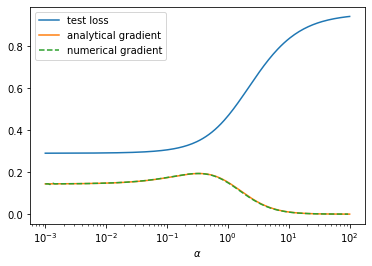

In [9]:
plt.semilogx()
plt.plot(alphas, test_losses, label='test loss')
plt.plot(alphas, grads, label='analytical gradient')
plt.plot(alphas[:-1], np.diff(test_losses) / np.diff(alphas), label='numerical gradient', linestyle='--')
plt.legend()
plt.xlabel("$\\alpha$")
plt.show()

In [10]:
# sweep over values of lambda, holding alpha=0, evaluating the gradient along the way
lams = np.logspace(-3, 2, 200)
test_losses = []
grads = []
for lam_vals in lams:
    lam_tch = torch.tensor([lam_vals], requires_grad=True)
    lam_tch.grad = None
    a_tch, b_tch = fit_lr(Xtrain, ytrain, lam_tch, torch.zeros(1))
    test_loss = (Xtest @ a_tch.flatten() + b_tch - ytest).pow(2).mean()
    test_loss.backward()
    test_losses.append(test_loss.item())
    grads.append(lam_tch.grad.item())

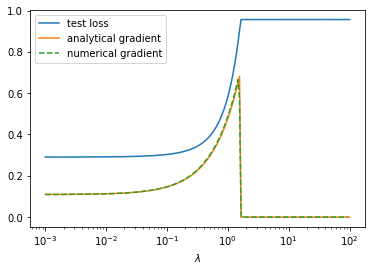

In [11]:
plt.semilogx()
plt.plot(lams, test_losses, label='test loss')
plt.plot(lams, grads, label='analytical gradient')
plt.plot(lams[:-1], np.diff(test_losses) / np.diff(lams), label='numerical gradient', linestyle='--')
plt.legend()
plt.xlabel("$\\lambda$")
plt.show()

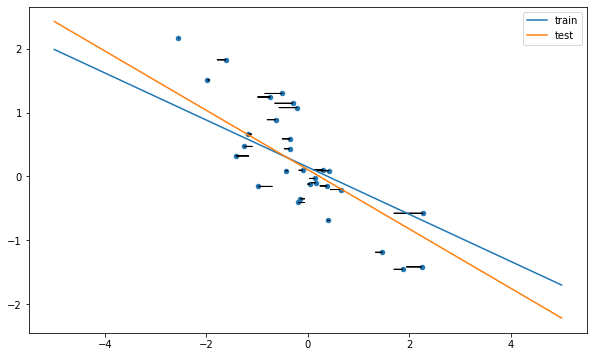

In [12]:
# compute the gradient of the test loss wrt all the training data points, and plot
plt.figure(figsize=(10, 6))
a_tch, b_tch = fit_lr(Xtrain, ytrain, torch.tensor([.05]), torch.tensor([.05]), solver_args={"eps": 1e-8})
test_loss = (Xtest @ a_tch.flatten() + b_tch - ytest).pow(2).mean()
test_loss.backward()
a_tch_test, b_tch_test = fit_lr(Xtest, ytest, torch.tensor([0.]), torch.tensor([0.]), solver_args={"eps": 1e-8})
plt.scatter(Xtrain.detach().numpy(), ytrain.numpy(), s=20)
plt.plot([-5, 5], [-3*a_tch.item() + b_tch.item(),3*a_tch.item() + b_tch.item()], label='train')
plt.plot([-5, 5], [-3*a_tch_test.item() + b_tch_test.item(), 3*a_tch_test.item() + b_tch_test.item()], label='test')
Xtrain_np = Xtrain.detach().numpy()
Xtrain_grad_np = Xtrain.grad.detach().numpy()
ytrain_np = ytrain.numpy()
for i in range(Xtrain_np.shape[0]):
    plt.arrow(Xtrain_np[i], ytrain_np[i],
              -.1 * Xtrain_grad_np[i][0], 0.)
plt.legend()
plt.show()

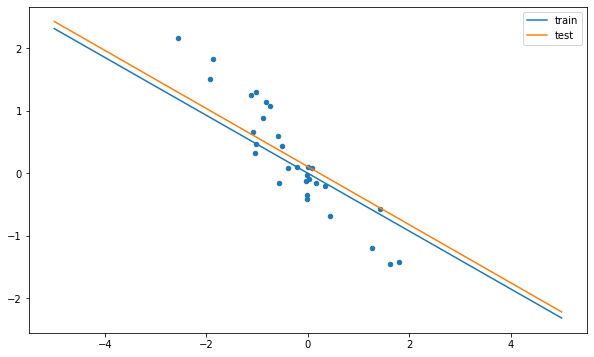

In [13]:
# move the training data points in the direction of their gradients, and see the train line get closer to the test line
plt.figure(figsize=(10, 6))
Xtrain_new = torch.from_numpy(Xtrain_np - .15 * Xtrain_grad_np)
a_tch, b_tch = fit_lr(Xtrain_new, ytrain, torch.tensor([.05]), torch.tensor([.05]), solver_args={"eps": 1e-8})
plt.scatter(Xtrain_new.detach().numpy(), ytrain.numpy(), s=20)
plt.plot([-5, 5], [-3*a_tch.item() + b_tch.item(),3*a_tch.item() + b_tch.item()], label='train')
plt.plot([-5, 5], [-3*a_tch_test.item() + b_tch_test.item(), 3*a_tch_test.item() + b_tch_test.item()], label='test')
plt.legend()
plt.show()